In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import multiprocessing as mp
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import curve_fit
import astropy.io.fits as fits

 ### Trabalho 2 
    - Fotometria de abertura em 8 frames de uma ocultação estelar.
    - Intuito de comparar curvas de luz -> faz-se necessário adquirir a medida do fluxo de cada frame
    

 ##### Perguntas a serem respondidas durante a análise:
    
    1. Qual o centróide (x,y) da estrela alvo?
    2. Qual a melhor abertura para fazermos a fotometria do nosso alvo?

 - Pipeline para fotometria de 1 frame:

Alvo = (x=216,y=177)

In [2]:
im_data = fits.getdata('1305.fits') #Durante o evento

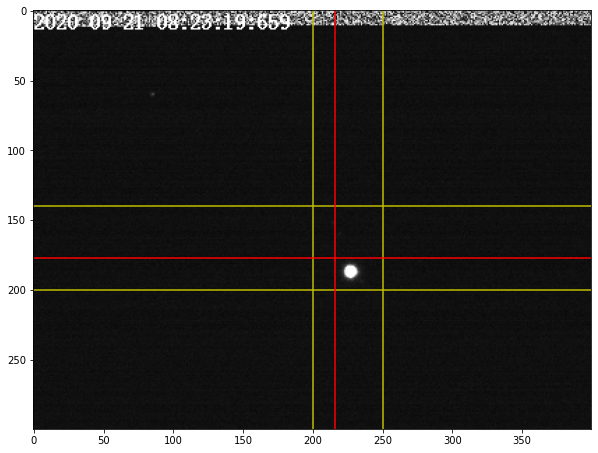

In [3]:
plt.figure(figsize=[10, 10])
plt.axvline(200, color='y')
plt.axvline(250, color='y')
plt.axhline(140, color='y')
plt.axhline(200, color='y')
plt.axvline(216, color='r') #Estrela alvo
plt.axhline(177, color='r') #Estrela alvo
#plt.axvline(261, color='b') #Estrela comparação
#plt.axhline(279, color='b') #Estrela comparação
plt.imshow(im_data, cmap='gray')
plt.show()

In [4]:
im_hd = fits.getheader('1305.fits')
im_hd

SIMPLE  =                    T / C# FITS: 9/21/2020 4:23:19 AM                  
BITPIX  =                   16                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                  400                                                  
NAXIS2  =                  300                                                  
OBSLAT  =     44.2612833333333 /                                                
GPSSTAT = 'Locked  '           /                                                
DATE-END= '2020-09-21T08:23:19.7450000' / System Clock-Frame Grabbed            
DATE-OBS= '2020-09-21T08:23:19.6599805' / GPS-Start Exp                         
SWCREATE= 'SharpCap'           /                                                
CCD-TEMP=                 -7.1 /                                                
YBINNING=                    2 /                                                
YPIXSZ  =      5.86000013351

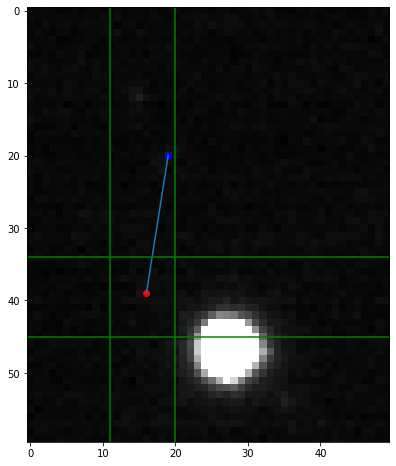

In [5]:
new_data = im_data[140:200,200:250]
plt.figure(figsize=[8, 8])
plt.imshow(new_data, cmap='gray')


## Alvo (inferindo esta posição graças ao calibrador titania.)
plt.plot(16, 39, 'ro') 

##Calibrador
plt.plot(19, 20, 'bo') #Antes estava (18,20) -> dx=+1 dy=0


## Distancia entre eles
#plt.plot([1, 10], [1, 10]) irá traçar uma reta ligando os pontos (1,1) e (10,10)
plt.plot([19,16],[20,39])


plt.axvline(11, color='g')
plt.axvline(20, color='g')
plt.axhline(45, color='g')
plt.axhline(34, color='g')
plt.show()

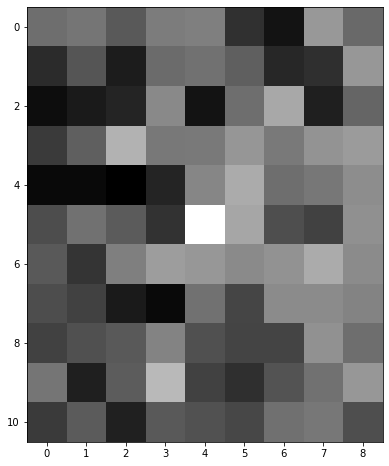

In [6]:
im_alvo = new_data[36:47,7:18] # Imagem recortada de forma a vizualizar a abertura mais completamente. Usar essa variavel para fazer a fotometria torna o brilho de Urano relevante demais na contagem, desviando o centro.
#alvo = new_data[30:44,10:20] # Imagem da estrela alvo mais isolada possivel de Urano. Descartado temporariamente pois ainda é muito afetada por Urano o que afeta o calculo do centro.
alvo = new_data[34:45,11:20] # Imagem da estrela alvo mais isolada possível de Urano. Este recorte limita muito o anel do fundo de ceu.
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray')
#plt.axvline(15, color='r')
#plt.axhline(36, color='r')
#plt.axvline(61, color='g')
#plt.axhline(79, color='g')
plt.show()

In [7]:
def momento(data):
    '''
    Função que devolve o fotocentro da imagem utilizando o método do momento.
    '''
    I_i = np.sum(data, axis=0)
    I_j = np.sum(data, axis=1)
    Ii_mean = np.sum(I_i)/len(I_i)
    Ij_mean = np.sum(I_j)/len(I_j)

    x_i = np.arange(data.shape[1])
    y_j = np.arange(data.shape[0])
    mask_i = (I_i - Ii_mean) > 0
    mask_j = (I_j - Ij_mean) > 0

    xc = np.sum((I_i - Ii_mean)[mask_i]*x_i[mask_i])/np.sum((I_i - Ii_mean)[mask_i])
    yc = np.sum((I_j - Ij_mean)[mask_j]*y_j[mask_j])/np.sum((I_j - Ij_mean)[mask_j])
    return xc, yc

In [8]:
xc, yc = momento(alvo)
print(xc, yc)

6.169582862085024 4.604042400662597


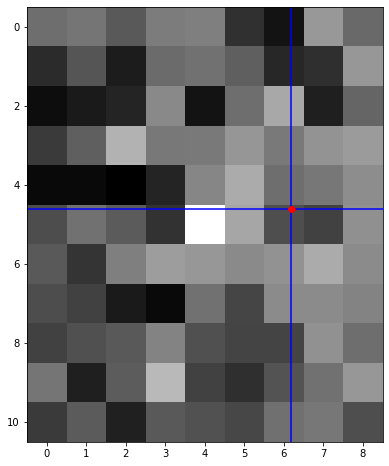

In [9]:
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray', 
          # vmin=alvo.mean()-1000, vmax=alvo.mean()+1000
          )

plt.axhline(yc, color='blue')
plt.axvline(xc, color='blue')
plt.plot(xc, yc, 'ro')

plt.show()

    Os valores encontrados no ultimo frame em que o corpo não estava sendo ocultado servem de guia. Novamente o método do pixel mais brilhante parece o ideal.

In [10]:
xc = 6.36
yc = 5.16

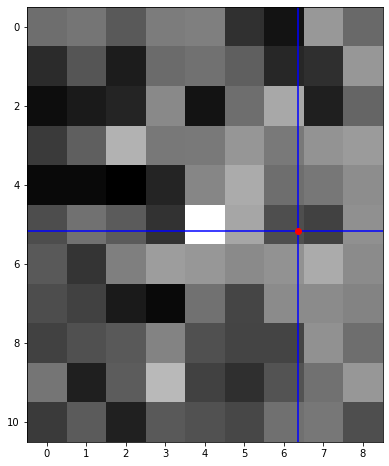

In [11]:
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray', 
          # vmin=alvo.mean()-1000, vmax=alvo.mean()+1000
          )

plt.axhline(yc, color='blue')
plt.axvline(xc, color='blue')
plt.plot(xc, yc, 'ro')

plt.show()

In [12]:
np.where(alvo == alvo.max())

(array([5]), array([4]))

In [13]:
yc = 5
xc = 4

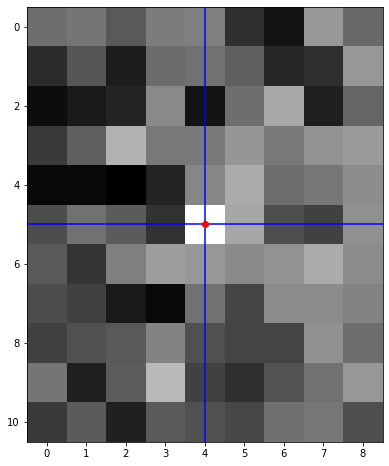

In [14]:
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray', 
          # vmin=alvo.mean()-1000, vmax=alvo.mean()+1000
          )

plt.axhline(yc, color='blue')
plt.axvline(xc, color='blue')
plt.plot(xc, yc, 'ro')

plt.show()

 - Agora determinamos os pixels que iremos somar

In [15]:
y = np.arange(alvo.shape[0])
x = np.arange(alvo.shape[1])

x, y = np.meshgrid(x, y)

- Queremos indentificar a melhor abertura

In [16]:
fluxos = np.array([])
abertura = np.arange(1,8)

for i in abertura:
    mask = np.sqrt((x - xc)**2 + (y - yc)**2) < i
    fluxos = np.append(fluxos, np.sum(alvo[mask]))

Text(0.5, 0, 'Fuxo [contagens]')

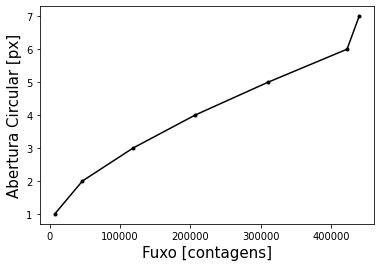

In [17]:
plt.plot(fluxos, abertura, 'k.-')
plt.ylabel('Abertura Circular [px]', fontsize=15)
plt.xlabel('Fuxo [contagens]', fontsize=15)

 - Determinando o fundo de céu...

In [18]:
outer_ring = 5
inner_ring = 3

mask_sky = ((np.sqrt((x - xc)**2 + (y - yc)**2) < outer_ring) 
           *(np.sqrt((x - xc)**2 + (y - yc)**2) > inner_ring))


image_sky = np.copy(alvo.astype('float64')) # Puramente para ilustração
image_sky[~mask_sky] = np.nan  # Puramente para ilustração

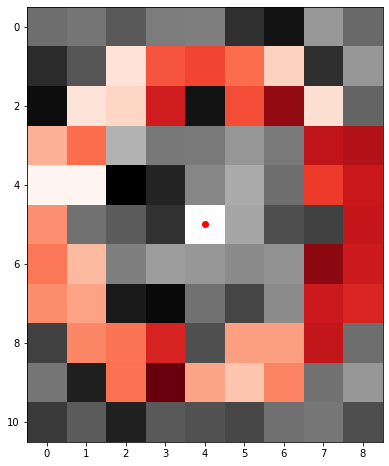

In [19]:
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray')
plt.imshow(image_sky, cmap='Reds', 
           #alpha=1.0
          )
plt.plot(xc, yc, 'ro')
plt.show()

In [20]:
flux_sky = np.sum(alvo[mask_sky])
print('Flux do céu:', flux_sky)

npix_sky = len(alvo[mask_sky])
print('Número de pixeis:', npix_sky)
print('\n')
print('Distribuição do Fundo do céu:' + 
      '{:.2f} +/- {:.2f}'.format(alvo[mask_sky].mean(),
                                 alvo[mask_sky].std()))

Flux do céu: 176159
Número de pixeis: 40


Distribuição do Fundo do céu:4403.98 +/- 768.93


 - Agora podemos analisar a melhor abertura possivel

In [21]:
fluxos = np.array([])
npixs = np.array([])

abertura = np.arange(1,8)
for i in abertura:
    mask = np.sqrt((x - xc)**2 + (y - yc)**2) < i
    fluxos = np.append(fluxos, np.sum(alvo[mask]))
    npixs  = np.append(npixs, len(alvo[mask]))

    
fluxos_new = fluxos - npixs*alvo[mask_sky].mean()

snr = fluxos_new/np.sqrt(fluxos_new + 
                         npixs*alvo[mask_sky].mean())

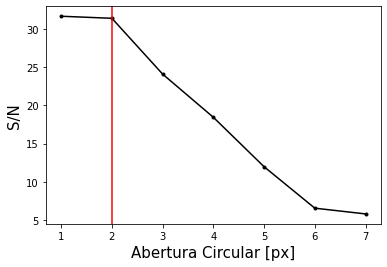

In [22]:
plt.plot(abertura, snr, 'k.-')
plt.xlabel('Abertura Circular [px]', fontsize=15)
plt.ylabel('S/N', fontsize=15)
plt.axvline(2, color='r')
#plt.axhline(587.83, color = 'g')
plt.show()

In [23]:
abertura = 2

mask = np.sqrt((x - xc)**2 + (y - yc)**2) < abertura

image_copy = np.copy(alvo.astype('float64')) # Puramente para ilustração
image_copy[~mask] = np.nan  # Puramente para ilustração

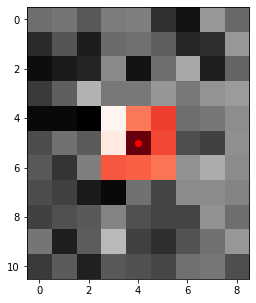

In [24]:
plt.figure(figsize=[5, 5])
plt.imshow(alvo, cmap='gray', 
          #vmin=im_data.mean()-100, 
          #vmax=im_data.mean()+100
          )

plt.imshow(image_copy, cmap='Reds', 
          #vmin=im_data.mean()-100, 
          #vmax=im_data.mean()+100
        )
plt.plot(xc, yc, 'ro')
plt.show()

In [25]:
fluxo = np.sum(alvo[mask])
print(fluxo)

npix = len(alvo[mask])
print(npix)

46404
9


In [26]:
flux_sky = np.sum(alvo[mask_sky])
print('Flux do céu:', flux_sky)

npix_sky = len(alvo[mask_sky])
print('Número de pixeis:', npix_sky)
print('\n')
print('Distribuição do Fundo do céu:' + 
      '{:.2f} +/- {:.2f}'.format(alvo[mask_sky].mean(),
                                 alvo[mask_sky].std()))

Flux do céu: 176159
Número de pixeis: 40


Distribuição do Fundo do céu:4403.98 +/- 768.93


In [27]:
fluxo_correto = fluxo - npix*alvo[mask_sky].mean()

snr = (fluxo_correto/np.sqrt((fluxo_correto + 
       npix*alvo[mask_sky].mean())))

print('S/N:', snr) #Realista!
print('Fluxo do alvo: ', fluxo_correto)

S/N: 31.419341503058927
Fluxo do alvo:  6768.2249999999985


 - Calibrador

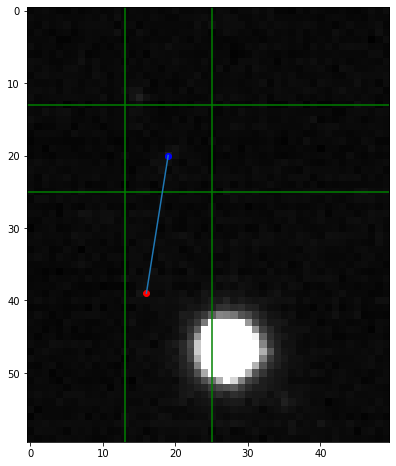

In [28]:
new_data = im_data[140:200,200:250]
plt.figure(figsize=[8, 8])
plt.imshow(new_data, cmap='gray')

plt.axvline(13, color='g')
plt.axvline(25, color='g')
plt.axhline(25, color='g')
plt.axhline(13, color='g')

##Calibrador
plt.plot(19, 20, 'bo') #Antes estava (18,20) -> dx=+1 dy=0

## Alvo 
plt.plot(16, 39, 'ro') 

## Distancia entre eles
#plt.plot([1, 10], [1, 10]) irá traçar uma reta ligando os pontos (1,1) e (10,10)
plt.plot([19,16],[20,39])


plt.show()

In [29]:
def reta_entre_pts(xa,xb,ya,yb):
    return np.sqrt((xb-xa)**2 + (yb - ya)**2)
print('Distancia entre Titania e Estrela alvo + Umbriel: ',reta_entre_pts(19,16,39,20))

Distancia entre Titania e Estrela alvo + Umbriel:  19.235384061671343


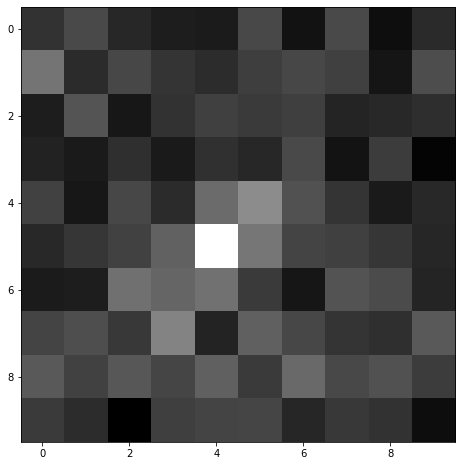

In [30]:
cal = new_data[15:25,15:25] # Imagem do calibrador -> Titania
plt.figure(figsize=[8, 8])
plt.imshow(cal, cmap='gray')
plt.show()

In [31]:
xc, yc = momento(cal)
print(xc, yc)

4.242802496476747 6.095177593631589


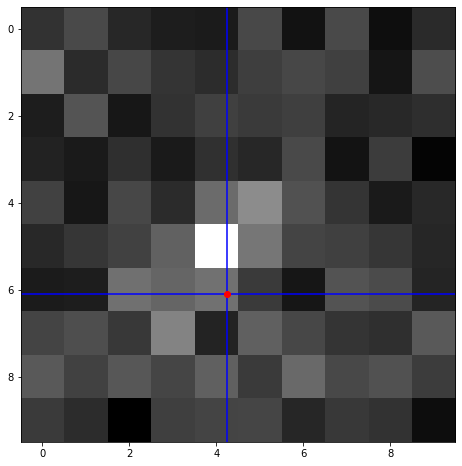

In [32]:
plt.figure(figsize=[8, 8])
plt.imshow(cal, cmap='gray')
plt.axhline(yc, color='blue')
plt.axvline(xc, color='blue')
plt.plot(xc, yc, 'ro')
plt.show()

In [33]:
y = np.arange(cal.shape[0])
x = np.arange(cal.shape[1])

x, y = np.meshgrid(x, y)

outer_ring = 5
inner_ring = 3

mask_sky = ((np.sqrt((x - xc)**2 + (y - yc)**2) < outer_ring) 
           *(np.sqrt((x - xc)**2 + (y - yc)**2) > inner_ring))


image_sky = np.copy(cal.astype('float64')) # Puramente para ilustração
image_sky[~mask_sky] = np.nan  # Puramente para ilustração

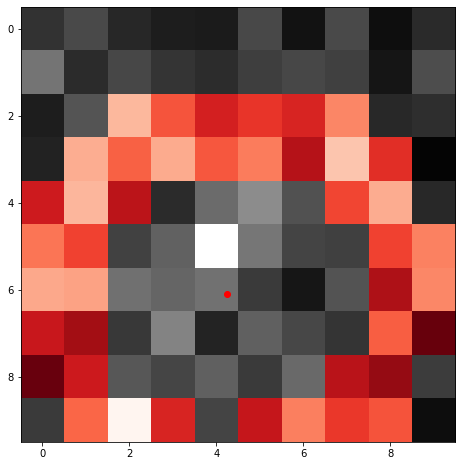

In [34]:
plt.figure(figsize=[8, 8])
plt.imshow(cal, cmap='gray')
plt.imshow(image_sky, cmap='Reds', 
           #alpha=1.0
          )
plt.plot(xc, yc, 'ro')
plt.show()

In [35]:
flux_sky = np.sum(cal[mask_sky])
print('Flux do céu:', flux_sky)

npix_sky = len(cal[mask_sky])
print('Número de pixeis:', npix_sky)
print('\n')
print('Distribuição do Fundo do céu:' + 
      '{:.2f} +/- {:.2f}'.format(cal[mask_sky].mean(),
                                 cal[mask_sky].std()))

Flux do céu: 169832
Número de pixeis: 42


Distribuição do Fundo do céu:4043.62 +/- 553.64


In [36]:
abertura = 2 # Sempre usarei essa abertura pois é a melhor, na média, entre os frames.

mask = np.sqrt((x - xc)**2 + (y - yc)**2) < abertura

image_copy = np.copy(cal.astype('float64')) # Puramente para ilustração
image_copy[~mask] = np.nan  # Puramente para ilustração

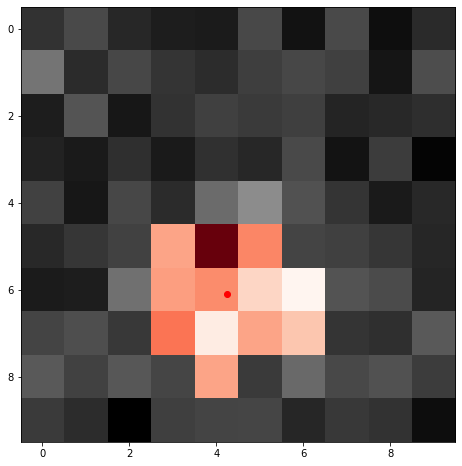

In [37]:
plt.figure(figsize=[8, 8])
plt.imshow(cal, cmap='gray', 
          #vmin=im_data.mean()-100, 
          #vmax=im_data.mean()+100
          )

plt.imshow(image_copy, cmap='Reds', 
          #vmin=im_data.mean()-100, 
          #vmax=im_data.mean()+100
        )
plt.plot(xc, yc, 'ro')
plt.show()

In [38]:
fluxo = np.sum(cal[mask])
print(fluxo)

npix = len(cal[mask])
print(npix)
flux_sky = np.sum(cal[mask_sky])
print('Flux do céu:', flux_sky)

npix_sky = len(cal[mask_sky])
print('Número de pixeis:', npix_sky)
print('\n')
print('Distribuição do Fundo do céu:' + 
      '{:.2f} +/- {:.2f}'.format(cal[mask_sky].mean(),
                                 cal[mask_sky].std()))

64295
12
Flux do céu: 169832
Número de pixeis: 42


Distribuição do Fundo do céu:4043.62 +/- 553.64


In [39]:
fluxo_cal = fluxo - npix*cal[mask_sky].mean()

snr = (fluxo_cal/np.sqrt((fluxo_cal + 
       npix*cal[mask_sky].mean())))

print('S/N do Calibrador:', snr) #Realista!
print('Fluxo do Calibrador: ', fluxo_cal)

S/N do Calibrador: 62.199424565731476
Fluxo do Calibrador:  15771.571428571428


In [40]:
flux_ratio = 6768.22/15771.57
flux_ratio

0.42914053578686207